In [2]:
# # 1. Check your PyTorch + CUDA versions:
# import torch
# print(torch.__version__)        # e.g. 2.0.1+cu118
# print(torch.version.cuda)       # e.g. 11.8

# # 2. Install PyG C-extensions + torch-geometric:
# CUDA = torch.version.cuda.replace('.', '')  # e.g. '118'
# TORCH = torch.__version__.split('+')[0]      # e.g. '2.0.1'
# WHL_URL = f"https://data.pyg.org/whl/torch-{TORCH}+cu{CUDA}.html"

# # Run these in Colab:
# !pip install torch-scatter -f {WHL_URL}
# !pip install torch-sparse  -f {WHL_URL}
# !pip install torch-cluster -f {WHL_URL}
# !pip install torch-spline-conv -f {WHL_URL}
# !pip install pyg-lib       -f {WHL_URL}
# !pip install torch-geometric

In [3]:
# !pip install captum

In [4]:
# Importing necessary modules

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch import Tensor

from torch_geometric.explain import CaptumExplainer, Explainer, Explanation
from torch_geometric.nn import SAGEConv, to_hetero
import torch_geometric.transforms as T

In [5]:
# Print torch Version
print(torch.__version__)

import os
os.environ['TORCH'] = torch.__version__

# Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2.6.0+cu124
cpu


In [34]:
# Downloading the data set
from torch_geometric.data import download_url, extract_zip

DATA_URL = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
DATA_DIR = './dataset'

archive_path = download_url(DATA_URL, DATA_DIR)
extract_zip(archive_path, DATA_DIR)

Using existing file ml-latest-small.zip
Extracting ./dataset/ml-latest-small.zip


In [35]:
# Load and preview MovieLens data
movies_csv_path = './dataset/ml-latest-small/movies.csv'
ratings_csv_path = './dataset/ml-latest-small/ratings.csv'

movies_df = pd.read_csv(movies_csv_path, index_col='movieId')
movies_df.head()

title  \
movieId                                       
1                          Toy Story (1995)   
2                            Jumanji (1995)   
3                   Grumpier Old Men (1995)   
4                  Waiting to Exhale (1995)   
5        Father of the Bride Part II (1995)   

                                              genres  
movieId                                               
1        Adventure|Animation|Children|Comedy|Fantasy  
2                         Adventure|Children|Fantasy  
3                                     Comedy|Romance  
4                               Comedy|Drama|Romance  
5                                             Comedy

In [38]:
# One-hot encode movie genres
genre_dummies = movies_df['genres'].str.get_dummies('|')
genre_dummies.head()

(no genres listed)  Action  Adventure  Animation  Children  Comedy  \
movieId                                                                       
1                         0       0          1          1         1       1   
2                         0       0          1          0         1       0   
3                         0       0          0          0         0       1   
4                         0       0          0          0         0       1   
5                         0       0          0          0         0       1   

         Crime  Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  \
movieId                                                                         
1            0            0      0        1          0       0     0        0   
2            0            0      0        1          0       0     0        0   
3            0            0      0        0          0       0     0        0   
4            0            0      1        0          0       0     0        0   
5            0            0      0        0          0       0     0        0   

         Mystery  Romance  Sci-Fi  Thriller  War  Western  
movieId                                                    
1              0        0       0         0    0        0  
2              0        0       0         0    0        0  
3              0        1       0         0    0        0  
4              0        1       0         0    0        0  
5              0        0       0         0    0        0

In [36]:
# Load ratings DataFrame
ratings_df = pd.read_csv(ratings_csv_path)
ratings_df.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [40]:
# Prepare movie features and user-ID mapping
movie_features = torch.tensor(genre_dummies.values, dtype=torch.float)
assert movie_features.shape == genre_dummies.shape

unique_user_ids = ratings_df['userId'].unique()
print(f'Number of unique users: {len(unique_user_ids)}')

user_id_map = pd.DataFrame({
    'userId': unique_user_ids,
    'mappedId': range(len(unique_user_ids))
})
user_id_map

Number of unique users: 610


userId  mappedId
0         1         0
1         2         1
2         3         2
3         4         3
4         5         4
..      ...       ...
605     606       605
606     607       606
607     608       607
608     609       608
609     610       609

[610 rows x 2 columns]

In [42]:
# Prepare movie-ID mapping
unique_movie_ids = ratings_df['movieId'].unique()
print(f'Number of unique movies: {len(unique_movie_ids)}')

movie_id_map = pd.DataFrame({
    'movieId': movies_df.index,
    'mappedId': range(len(movies_df))
})
movie_id_map

Number of unique movies: 9724


movieId  mappedId
0           1         0
1           2         1
2           3         2
3           4         3
4           5         4
...       ...       ...
9737   193581      9737
9738   193583      9738
9739   193585      9739
9740   193587      9740
9741   193609      9741

[9742 rows x 2 columns]

In [43]:
# Attach mapped user IDs to the ratings
ratings_with_user = ratings_df.merge(
    user_id_map, on='userId', how='left'
)
ratings_with_user.head()

userId  movieId  rating  timestamp  mappedId
0       1        1     4.0  964982703         0
1       1        3     4.0  964981247         0
2       1        6     4.0  964982224         0
3       1       47     5.0  964983815         0
4       1       50     5.0  964982931         0

In [44]:
# Build edge_index for user→movie interactions
user_indices = torch.tensor(
    ratings_with_user['mappedId'].values, dtype=torch.long
)
movie_indices = ratings_df[['movieId']].merge(
    movie_id_map, on='movieId', how='left'
)
movie_indices = torch.tensor(
    movie_indices['mappedId'].values, dtype=torch.long
)

edge_index = torch.stack([user_indices, movie_indices], dim=0)
print(f'Edge index shape: {edge_index.shape}')
assert edge_index.shape[1] == len(ratings_df)

# Preview first 10 edges
edge_index[:, :10]


Edge index shape: torch.Size([2, 100836])


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   2,   5,  43,  46,  62,  89,  97, 124, 130]])

In [45]:
# Initialize HeteroData graph structure
from torch_geometric.data import HeteroData

hetero_data = HeteroData()

# Assign node indices and features
hetero_data['user'].node_id = torch.arange(len(unique_user_ids))
hetero_data['user'].x = torch.eye(hetero_data['user'].num_nodes, device=device)
hetero_data['movie'].node_id = torch.arange(len(movies_df))
hetero_data['movie'].x = movie_features

# Assign edges
hetero_data['user', 'rates', 'movie'].edge_index = edge_index

# Save and move to device
torch.save(hetero_data, "graph.pt")
hetero_data = hetero_data.to(device)
print(hetero_data)

HeteroData(
  user={
    node_id=[610],
    x=[610, 610],
  },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={ edge_index=[2, 100836] }
)


## Edge level training splits

In [130]:
data_undirected = T.ToUndirected()(hetero_data)

# Perform link-level split into training, validation, and test edges
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,  # percentage of edges used for supervision
    neg_sampling_ratio=2.0,     # 2 negative edges for 1 positive edge
    add_negative_train_samples=False,
    edge_types=('user','rates','movie'),
    rev_edge_types=('movie','rev_rates','user')
)

train_graph, val_graph, test_graph = transform(data_undirected)

class GNNEncoder(torch.nn.Module):
    """
    Graph Neural Network (GNN) encoder.
    Applies graph convolutional operations to input graph data.
    """
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

class EdgeDecoder(torch.nn.Module):
    """
    Decodes the information learned from node embeddings.
    """
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

class LinkPredictor(torch.nn.Module):
    """
    Model for encoding and decoding heterogeneous graphs.
    Combines GNNEncoder and EdgeDecoder for link prediction.
    """
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data_undirected.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

##  Mini-batch Loaders

In [131]:
# Create mini-batch neighbor loaders for training
from torch_geometric.loader import LinkNeighborLoader

# Prepare training labels
train_edge_idx = train_graph['user','rates','movie'].edge_label_index
train_edge_label = train_graph['user','rates','movie'].edge_label

train_loader = LinkNeighborLoader(
    data=train_graph,
    num_neighbors=[20,10],
    neg_sampling_ratio=2.0,
    edge_label_index=(('user','rates','movie'), train_edge_idx),
    edge_label=train_edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a batch
batch_data = next(iter(train_loader))
print("Batch sample:\n", batch_data)

assert batch_data['user','rates','movie'].edge_label_index.size(1) == 3 * 128
assert batch_data['user','rates','movie'].edge_label.min() == 0
assert batch_data['user','rates','movie'].edge_label.max() == 1

Batch sample:
 HeteroData(
  user={
    node_id=[610],
    x=[610, 610],
    n_id=[610],
    num_sampled_nodes=[3],
  },
  movie={
    node_id=[3704],
    x=[3704, 20],
    n_id=[3704],
    num_sampled_nodes=[3],
  },
  (user, rates, movie)={
    edge_index=[2, 21248],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[21248],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 8185],
    e_id=[8185],
    num_sampled_edges=[2],
  },
  (user, rev_rev_rates, movie)={
    edge_index=[2, 25416],
    e_id=[25416],
    num_sampled_edges=[2],
  },
  (movie, rev_rev_rev_rates, user)={
    edge_index=[2, 8510],
    e_id=[8510],
    num_sampled_edges=[2],
  },
  (user, rev_rev_rev_rev_rates, movie)={
    edge_index=[2, 25416],
    e_id=[25416],
    num_sampled_edges=[2],
  }
)


In [133]:
# Train link predictor model
import tqdm

link_pred_model = LinkPredictor(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(link_pred_model.parameters(), lr=0.001)

for epoch in range(1, 6):
    cumulative_loss = 0
    total_preds = 0
    for batch in tqdm.tqdm(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        predictions = link_pred_model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['user','rates','movie'].edge_label_index,
        )
        labels = batch['user','rates','movie'].edge_label
        loss = F.binary_cross_entropy_with_logits(predictions, labels)
        loss.backward()
        optimizer.step()
        cumulative_loss += float(loss) * predictions.numel()
        total_preds += predictions.numel()
    avg_loss = cumulative_loss / total_preds
    print(f"Epoch: {epoch:03d}, Train Loss: {avg_loss:.4f}")

100%|██████████| 190/190 [00:58<00:00,  3.25it/s]


Epoch: 001, Train Loss: 0.4256


100%|██████████| 190/190 [00:45<00:00,  4.15it/s]


Epoch: 002, Train Loss: 0.3333


100%|██████████| 190/190 [00:41<00:00,  4.63it/s]


Epoch: 003, Train Loss: 0.3091


100%|██████████| 190/190 [00:42<00:00,  4.45it/s]


Epoch: 004, Train Loss: 0.2957


100%|██████████| 190/190 [00:41<00:00,  4.53it/s]

Epoch: 005, Train Loss: 0.2761


In [134]:
model = link_pred_model

## Evaluating a Heterogeneous Link-level GNN

In [135]:
edge_label_index = val_graph["user","rates","movie"].edge_label_index
edge_label = val_graph["user", "rates","movie"].edge_label

val_loader = LinkNeighborLoader(
    data=val_graph,
    num_neighbors=[20,10],
    edge_label_index=(("user","rates","movie"), edge_label_index),
    edge_label=edge_label,
    batch_size = 3*128,
    shuffle = False
)

sampled_data = next(iter(val_loader))
print(f"sampled mini-batch: {sampled_data}")

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() >= 0
assert sampled_data["user", "rates", "movie"].edge_label.max() <= 1

sampled mini-batch: HeteroData(
  user={
    node_id=[610],
    x=[610, 610],
    n_id=[610],
    num_sampled_nodes=[3],
  },
  movie={
    node_id=[3595],
    x=[3595, 20],
    n_id=[3595],
    num_sampled_nodes=[3],
  },
  (user, rates, movie)={
    edge_index=[2, 23889],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[23889],
    num_sampled_edges=[2],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 8023],
    e_id=[8023],
    num_sampled_edges=[2],
  },
  (user, rev_rev_rates, movie)={
    edge_index=[2, 25392],
    e_id=[25392],
    num_sampled_edges=[2],
  },
  (movie, rev_rev_rev_rates, user)={
    edge_index=[2, 8040],
    e_id=[8040],
    num_sampled_edges=[2],
  },
  (user, rev_rev_rev_rev_rates, movie)={
    edge_index=[2, 25392],
    e_id=[25392],
    num_sampled_edges=[2],
  }
)


In [136]:
# Evaluate on validation set
from sklearn.metrics import roc_auc_score

val_edge_idx = val_graph['user','rates','movie'].edge_label_index
val_predictions = link_pred_model(
    val_graph.x_dict,
    val_graph.edge_index_dict,
    val_edge_idx,
).cpu().detach()
val_labels = val_graph['user','rates','movie'].edge_label.cpu()
val_auc = roc_auc_score(val_labels, val_predictions)
print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 0.9540


In [137]:
# Compute validation AUC over batches
from sklearn.metrics import roc_auc_score

print(f"Using device: {device}")

all_preds = []
all_labels = []
for batch in tqdm.tqdm(val_loader):
    batch = batch.to(device)
    with torch.no_grad():
        batch_preds = model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['user','rates','movie'].edge_label_index,
        )
    all_preds.append(batch_preds)
    all_labels.append(batch['user','rates','movie'].edge_label)

predictions = torch.cat(all_preds, dim=0).cpu().numpy()
labels = torch.cat(all_labels, dim=0).cpu().numpy()
val_auc_batched = roc_auc_score(labels, predictions)
print(f"Validation AUC (batched): {val_auc_batched:.4f}")

Using device: cpu


100%|██████████| 79/79 [00:11<00:00,  6.81it/s]

Validation AUC (batched): 0.9518


## Captum Explainer

In [138]:
# Cell 24: Using Captum Explainer to explain a single prediction
model = link_pred_model
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
    node_mask_type=None,
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type='topk',
        value=200,
    ),
)

index = torch.tensor([0])  # Explain edge with index 0
explanation = explainer(
    train_graph.x_dict,
    train_graph.edge_index_dict,
    index=index,
    edge_label_index=train_graph['user','rates','movie'].edge_label_index,
)
print(f'Generated explanations in {explanation.available_explanations}')

Generated explanations in ['edge_mask']


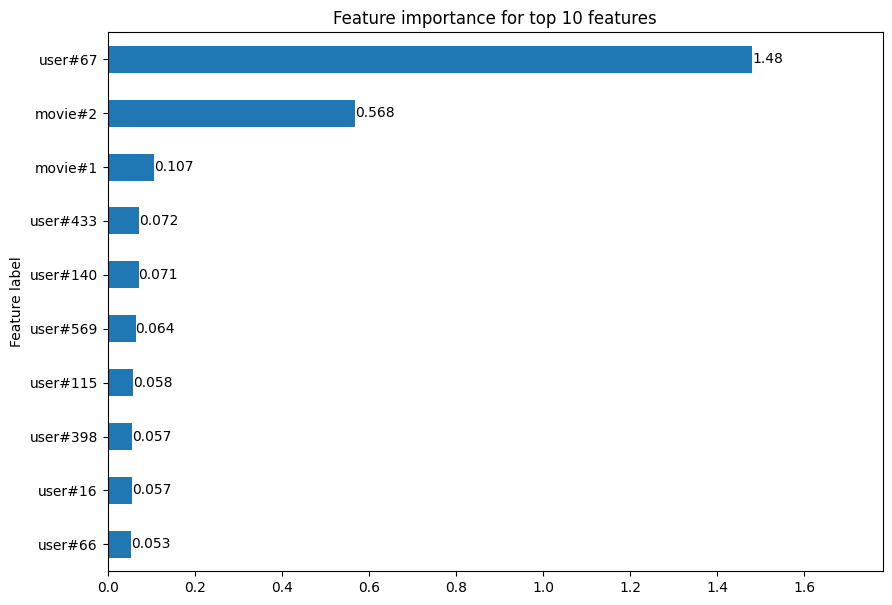

In [21]:
explanation.visualize_feature_importance(top_k=10)

## Plotting explanation graph


In [139]:
def create_nx_graph(data):
    # extracting the node and edge information to create a networkx graph so that we can calculate degree distribution
    edge_index = data['user',"rates",'movie']["edge_index"]
    user = [ f"U{int(i)}" for i in edge_index[0].unique()]
    movie = [ f"M{int(i)}" for i in edge_index[1].unique()]
    edges = [(f"U{int(edge_index[0][i])}",f"M{int(edge_index[1][i])}") for i in range(len(edge_index[0]))]

    # creating a heterogenous networkx graph

    hetero_graph = {'movie': movie,'user': user}
    edges_graph = {'user-rates-movie': edges}

    # Creating a NetworkX graph object
    graph = nx.Graph()

    # Adding nodes to the graph with node type information
    for node_type in hetero_graph:
        nodes = hetero_graph[node_type]
        for node in nodes:
            graph.add_node(node, type=node_type)

    # Adding edges to the graph
    for edge_type in edges_graph:
        edges = edges_graph[edge_type]
        if isinstance(edges[0], tuple):
            # If the edges are tuples, add them directly
            graph.add_edges_from(edges, label=edge_type)

    return graph

def save_target_nodes(user, movie):
    with open('target.txt','a') as f:
        target = str(movie) + "," + str(user)+"\n"
        f.write(target)

def retrieve_target_nodes():
    file_name = 'target.txt'
    with open(file_name,'r') as f:
        target = f.readline().split(',')
        movie, user = int(target[0]), int(target[1])

    os.remove(file_name)
    return movie, user


def target_graph_plot(index,data,train_data):
    target_edge_index = int(index)

    t_user = int(train_data["user", "rates", "movie"].edge_label_index[0][target_edge_index])
    t_movie = int(train_data["user", "rates", "movie"].edge_label_index[1][target_edge_index])
    print(f"User:{t_user} ----rates----> {t_movie}")

    save_target_nodes(t_user,t_movie)

    print("Graph being created")
    graph = create_nx_graph(data)
    print("Graph created")

    graph.add_node(t_user,type = "Target_user")
    graph.add_node(t_movie,type = "Target_movie")
    graph.add_edge(t_user,t_movie, label='Target_edge')
    # Specify node colors based on node types
    node_colors = {
        'movie': (0.69, 0.88, 0.9),
        'user': (0.56, 0.93, 0.56),
        'Target_user': (1.0, 0.0, 0.0),
        'Target_movie': (0.98, 0.502, 0.447)
    }

    # Specify edge colors based on edge types
    edge_colors = {
        'user-rates-movie': (0.8, 0.8, 0.8),
        'Target_edge': (0, 0,0)
    }

    # Create a layout for the graph
    layout = nx.spring_layout(graph, k = 1)
    plt.figure(figsize=(10, 8))
    # Draw nodes and edges
    node_color = [node_colors[graph.nodes[node]['type']] for node in graph.nodes()]
    edge_color = [edge_colors[graph.edges[edge]['label']] for edge in graph.edges()]
    nx.draw(graph, pos=layout, node_color=node_color, edge_color=edge_color, with_labels=True, node_size = 500)

    legend_labels = list(node_colors.keys()) + list(edge_colors.keys())
    legend_colors = list(node_colors.values())+ list(edge_colors.values())
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
    plt.legend(legend_elements, legend_labels)
    plt.show()


def graph2df ( gdata, data, link_exists, file_name, index ):

    tabular = []
    for i in range(len(gdata[0])):
        row = []
        movie_index = int(gdata[index][i])

        row.append(movie_index)
        row.extend([int(j) for j in data['movie'].x[movie_index]])
        row.append(int(gdata[0][i]))
        row.append(link_exists)
        tabular.append(row)

    df = pd.DataFrame(tabular, columns=["movie_id",'(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
        'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
        'War', 'Western',"user_id","link_exists"])
    df.to_csv(file_name,index=False)


User:480 ----rates----> 1220
Graph being created
Graph created


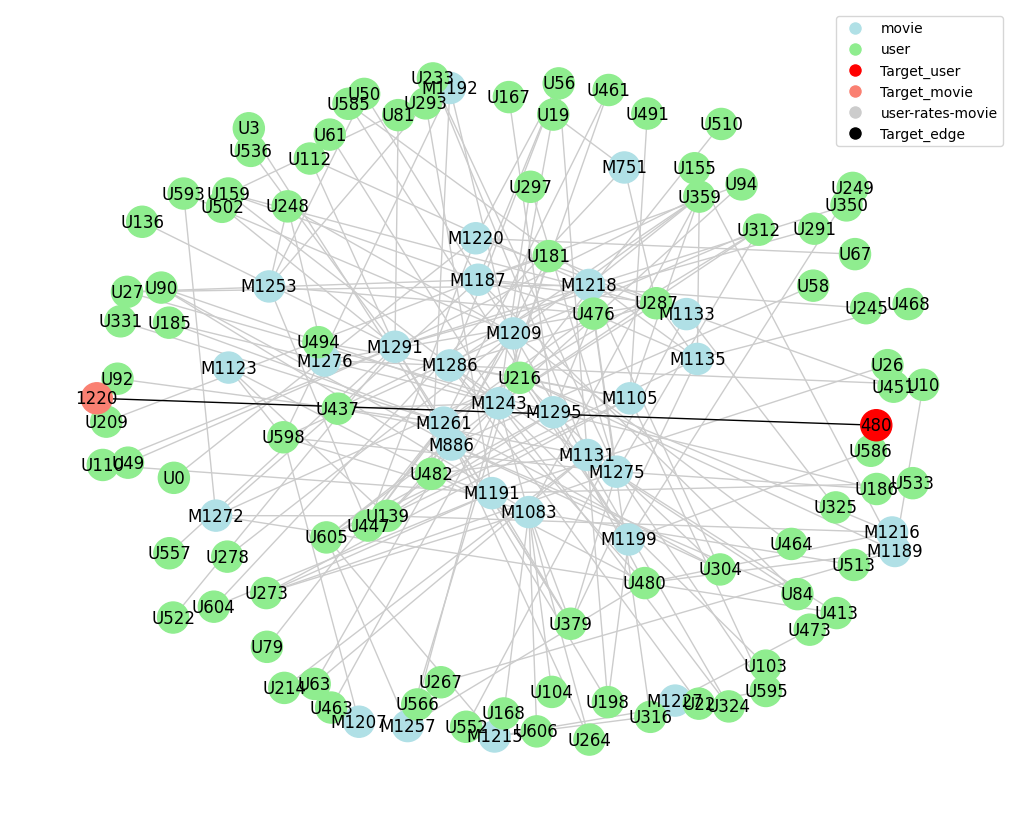

In [140]:
g  = explanation.get_explanation_subgraph()
target_graph_plot(index[0], g, train_graph)

In [28]:
# Plotting graph, with edges with 0 contribution are removed.

edgesu = []
edgesm = []

for i in range(len(explanation["user", "rates", "movie"]["edge_mask"])):
    if explanation["user", "rates", "movie"]["edge_mask"][i] != 0:
        edgesu.append(int(explanation["user", "rates", "movie"]["edge_index"][0][i]))
        edgesm.append(int(explanation["user", "rates", "movie"]["edge_index"][1][i]))

edges = torch.stack([torch.tensor(edgesu), torch.tensor(edgesm)], dim = 0)

masked_graph = HeteroData()
masked_graph['user', 'rates', 'movie'].edge_index = edges

In [141]:
preserved_src = []
preserved_dst = []

edge_info = explanation['user','rates','movie']
for src, dst, weight in zip(
    edge_info.edge_index[0],
    edge_info.edge_index[1],
    edge_info.edge_mask
):
    if weight != 0:
        preserved_src.append(int(src))
        preserved_dst.append(int(dst))

preserved_edges = torch.tensor([preserved_src, preserved_dst], dtype=torch.long)

masked_data = HeteroData()
masked_data['user','rates','movie'].edge_index = preserved_edges

User:480 ----rates----> 1220
Graph being created
Graph created


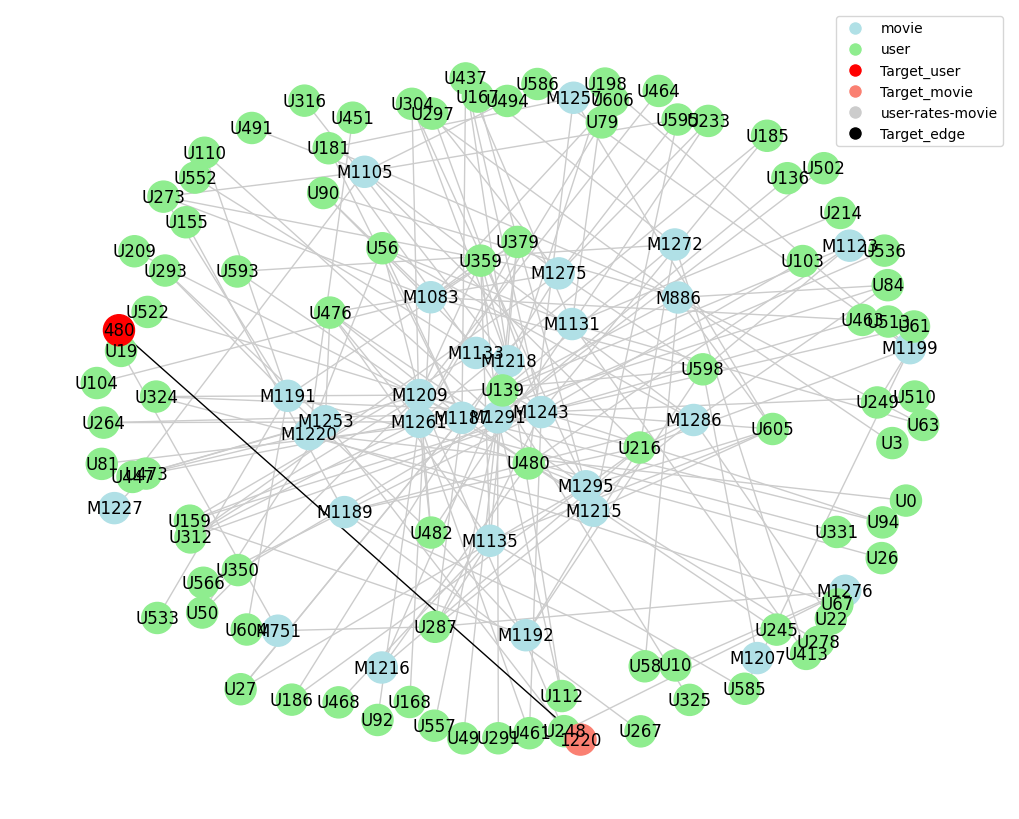

In [142]:
# Unmasked Edges
target_graph_plot(index[0], masked_data, train_graph)

In [143]:
g  = explanation.get_explanation_subgraph()

In [144]:
def get_subgraphs(g, threshold):
    g = g["user", "rates", "movie"]

    edges = []
    user, movie = [],[]
    unimp_user, unimp_movie, unimp_edges = [],[],[]

    for i in range(len(g.edge_mask)):
        if g.edge_mask[i] > threshold:
            edges.append((f"U{int(g.edge_index[0][i])}",f"M{int(g.edge_index[1][i])}"))
            user.append(f"U{int(g.edge_index[0][i])}")
            movie.append(f"M{int(g.edge_index[1][i])}")
        else:
            unimp_edges.append((f"U{int(g.edge_index[0][i])}",f"M{int(g.edge_index[1][i])}"))
            unimp_user.append(f"U{int(g.edge_index[0][i])}")
            unimp_movie.append(f"M{int(g.edge_index[1][i])}")

    #print(len(edges), len(user), len(movie), len(unimp_edges), len(unimp_user),len(unimp_movie))
    user = list(set(user))
    movie = list(set(movie))
    unimp_movie =list(set(unimp_movie))
    unimp_user = list(set(unimp_user))
    #print(len(edges), len(user), len(movie), len(unimp_edges), len(unimp_user),len(unimp_movie))

    hetero_graph = {'movie': movie,'user': user, 'unimp_user': unimp_user, 'unimp_movie': unimp_movie}
    edges_graph = {'user-rates-movie': edges, 'unimp_edges':unimp_edges}

# #     # Create a NetworkX graph object
    graph = nx.Graph()

# #     # Add nodes to the graph with node type information
    for node_type in hetero_graph:
        nodes = hetero_graph[node_type]
        graph.add_nodes_from(nodes, type=node_type)

# #     # Add edges to the graph
    for edge_type in edges_graph:
        edges = edges_graph[edge_type]
        graph.add_edges_from(edges, label=edge_type)

    target_edge_index = int(index[0])
    t_user = int(train_data["user", "rates", "movie"].edge_label_index[0][target_edge_index])
    t_movie = int(train_data["user", "rates", "movie"].edge_label_index[1][target_edge_index])

    graph.add_node(t_user,type = "Target_user")
    graph.add_node(t_movie,type = "Target_movie")
    graph.add_edge(t_user,t_movie, label='Target_edge')

    node_colors = {
        'movie': (0.69, 0.88, 0.9),
        'user': (0.56, 0.93, 0.56),
        'Target_user': (1.0, 0.0, 0.0),
        'Target_movie': (0.98, 0.502, 0.447),
        'unimp_user': (0.9, 0.9, 0.9),
        'unimp_movie': (0.9, 0.9, 0.9)
        # Add more node types and colors as needed
    }

    # Specify edge colors based on edge types
    edge_colors = {
        'user-rates-movie':(0.6, 0.6, 0),
        'Target_edge': (0.5, 0, 1),
        'unimp_edges':(0.9, 0.9, 0.9)
        # Add more edge types and colors as needed
    }
    plt.figure(figsize=(10, 8))
    node_color = [node_colors[graph.nodes[node]['type']] for node in graph.nodes()]
    edge_color = [edge_colors[graph.edges[edge]['label']] for edge in graph.edges()]
    nx.draw(graph, with_labels=True, node_size=1000,node_color=node_color, edge_color=edge_color, alpha=0.8, pos=nx.spring_layout(graph, k =1))

    #plt.title(f'GNNExplainer on node {node_idx}: label = {ba_shapes_data.y[node_idx]}, pred = {pred}')
    plt.show()

    print(graph)

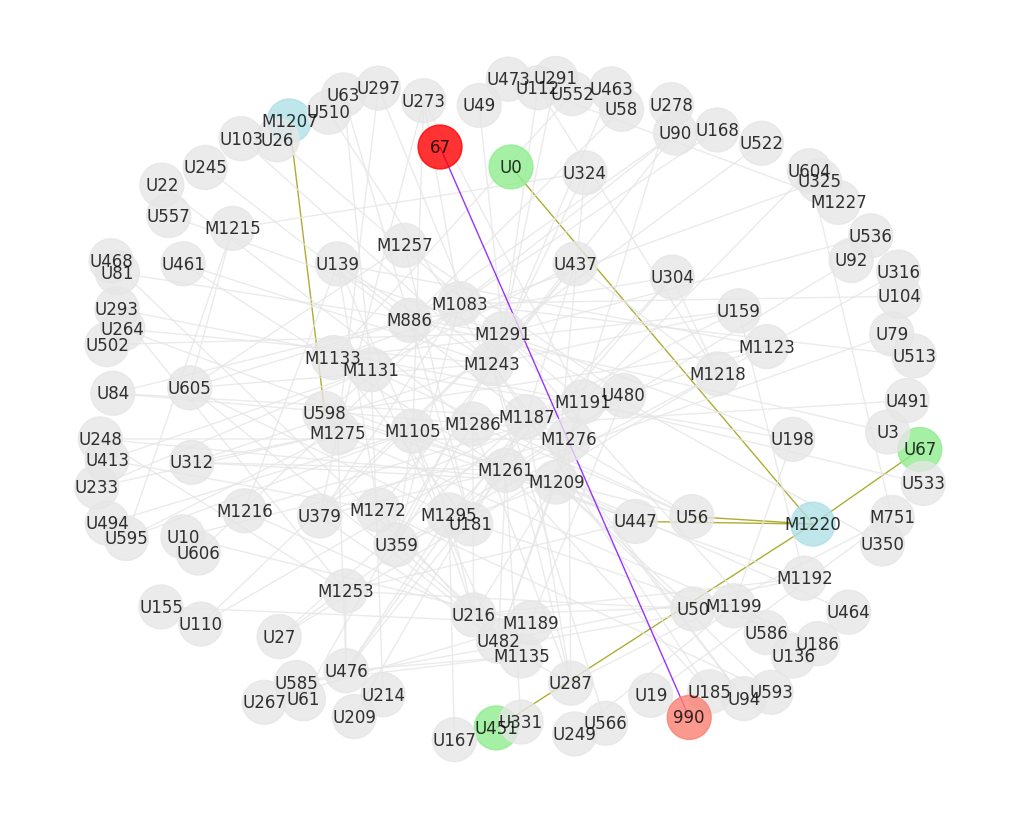

Graph with 121 nodes and 201 edges


In [145]:
get_subgraphs(g,threshold = 0.001)

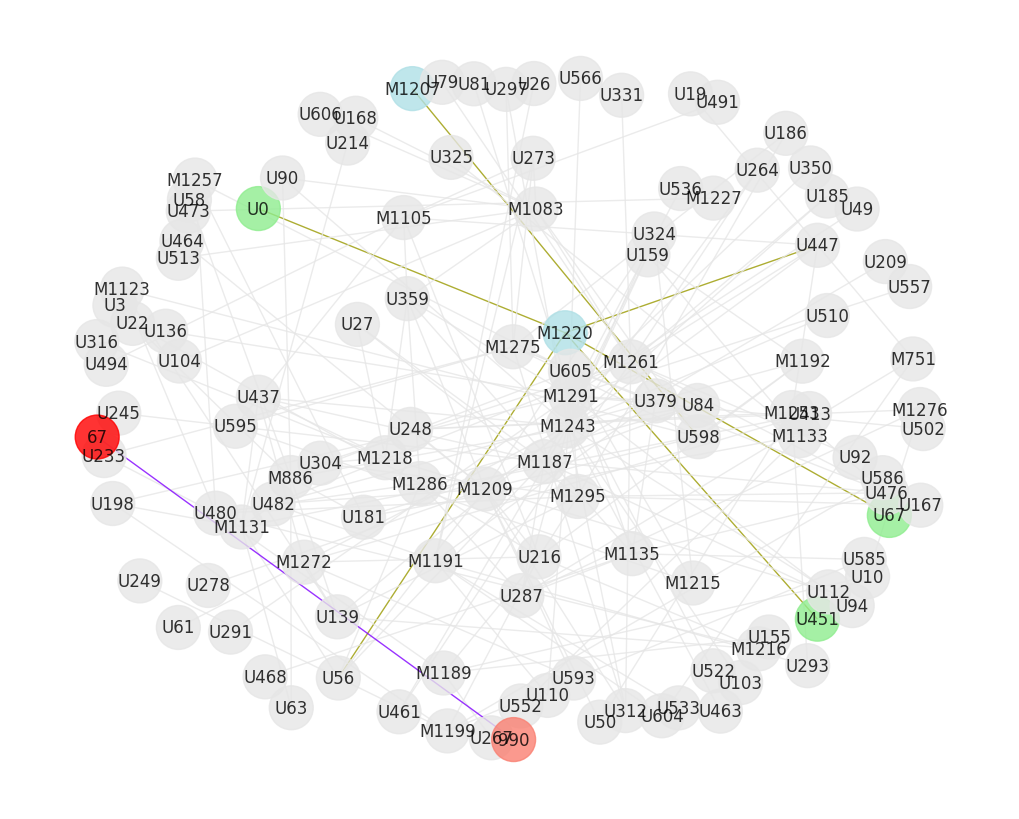

Graph with 121 nodes and 201 edges


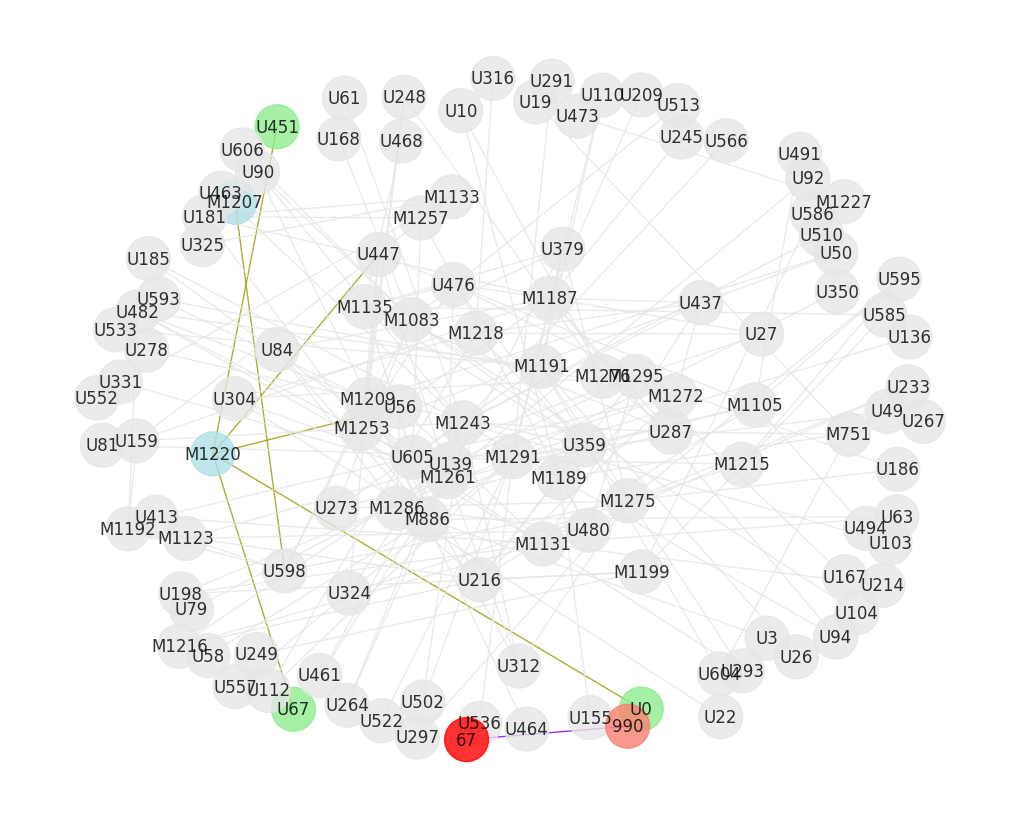

Graph with 121 nodes and 201 edges


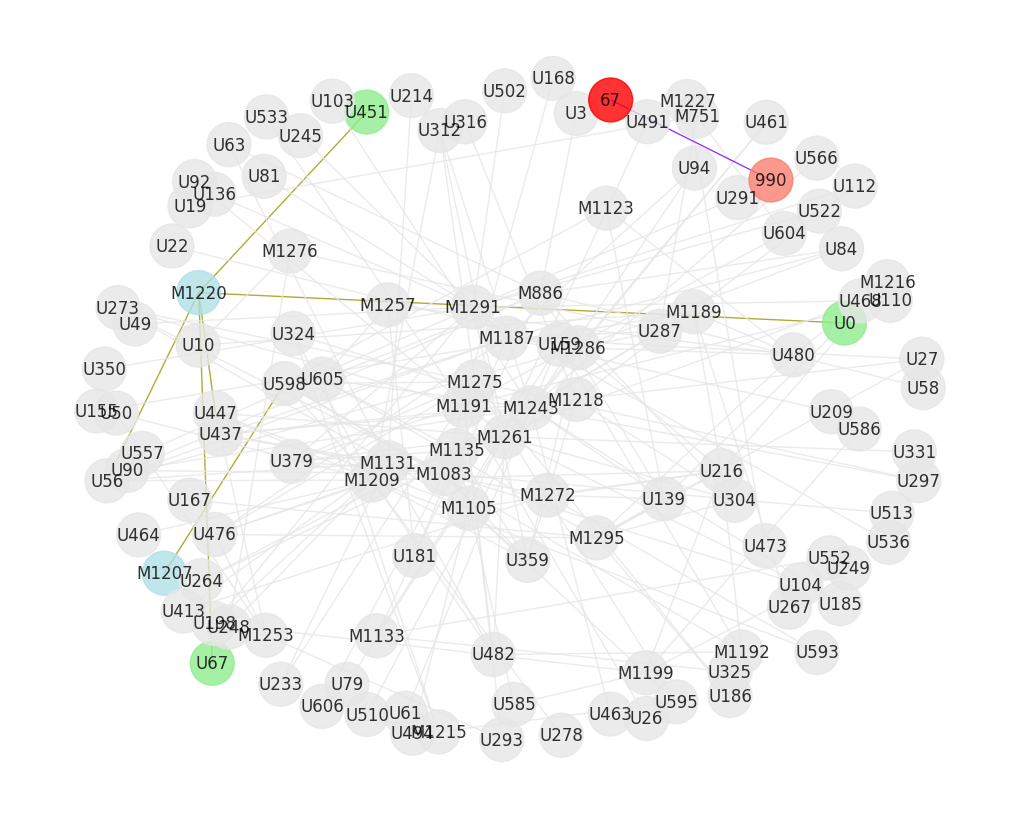

Graph with 121 nodes and 201 edges


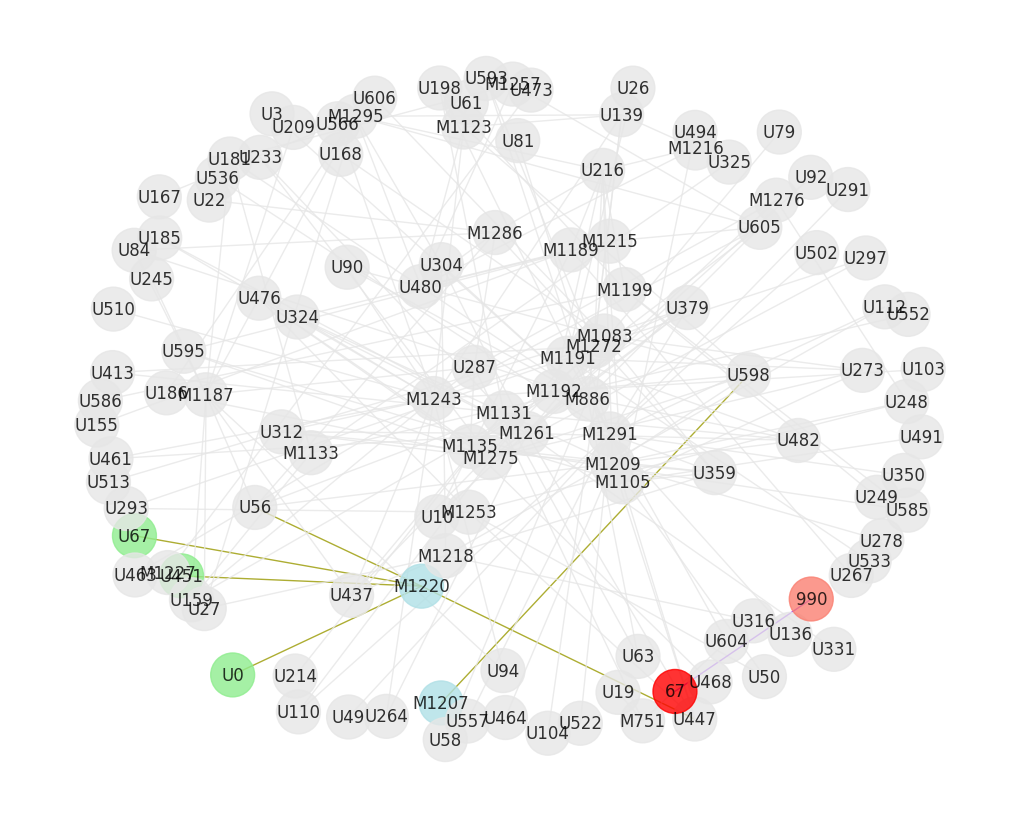

Graph with 121 nodes and 201 edges


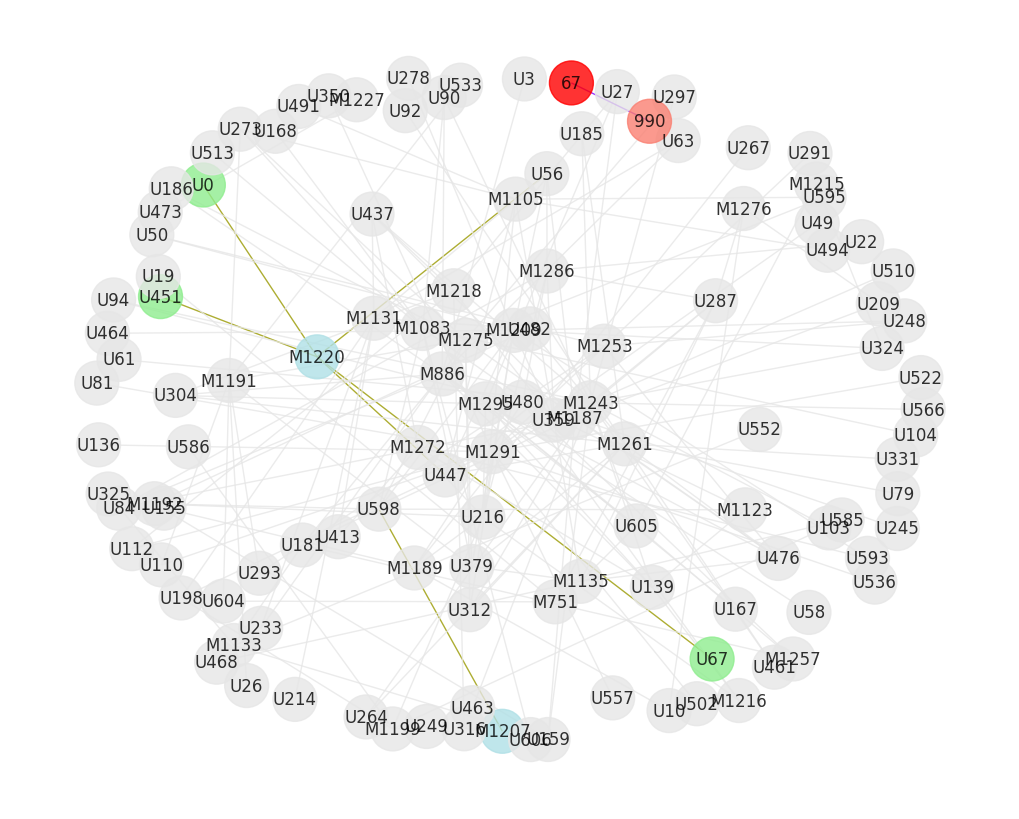

Graph with 121 nodes and 201 edges


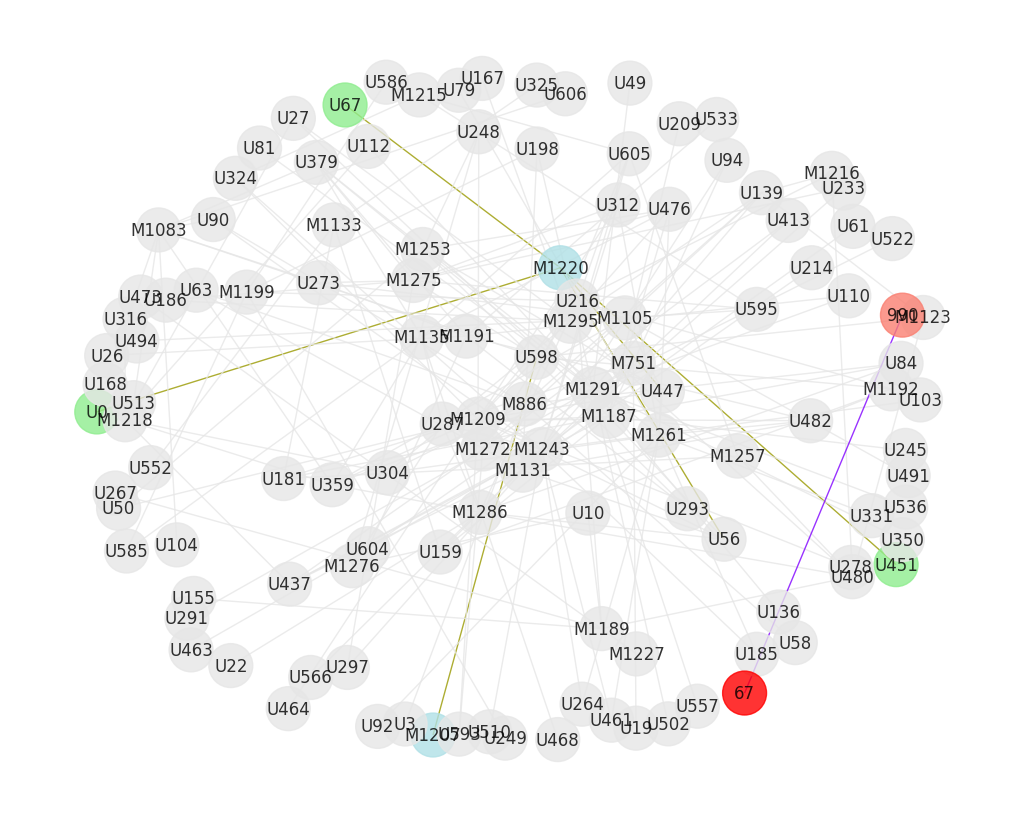

Graph with 121 nodes and 201 edges


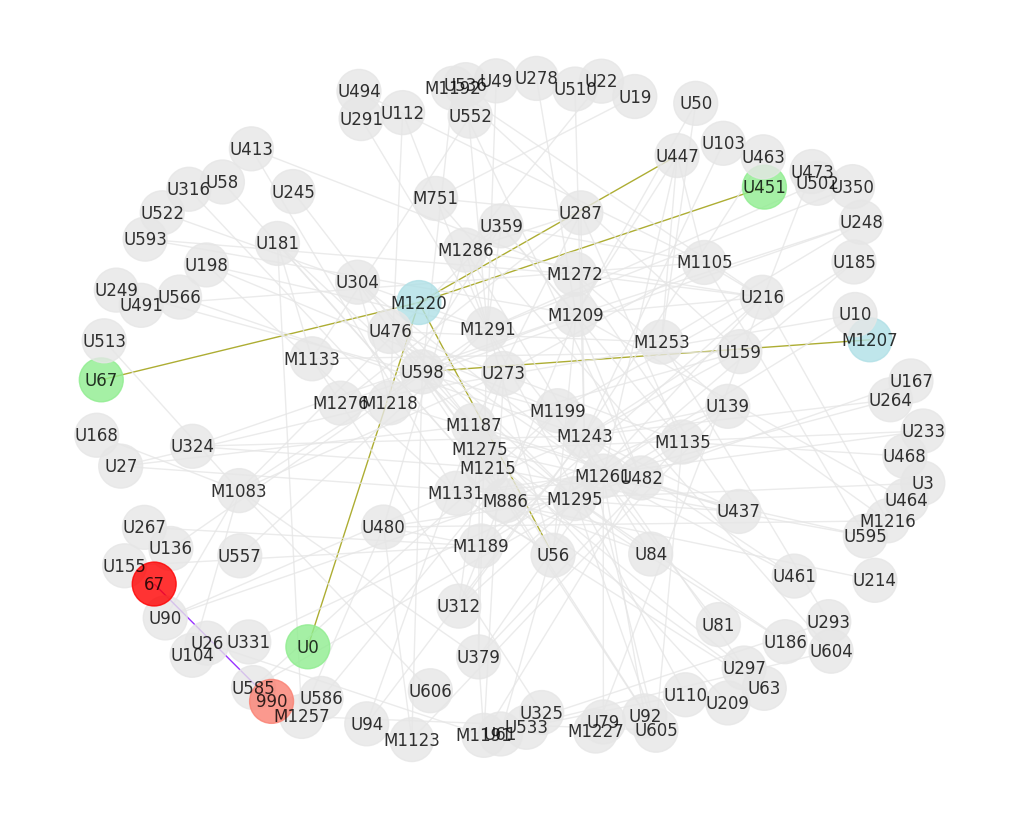

Graph with 121 nodes and 201 edges


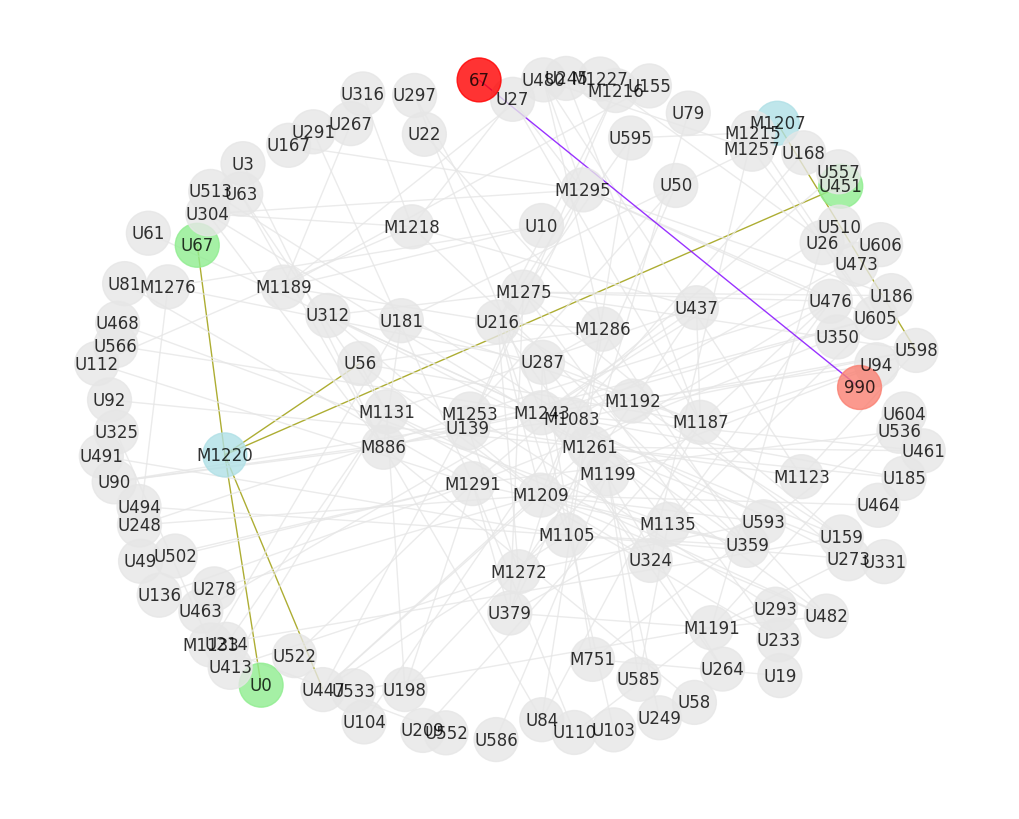

Graph with 121 nodes and 201 edges


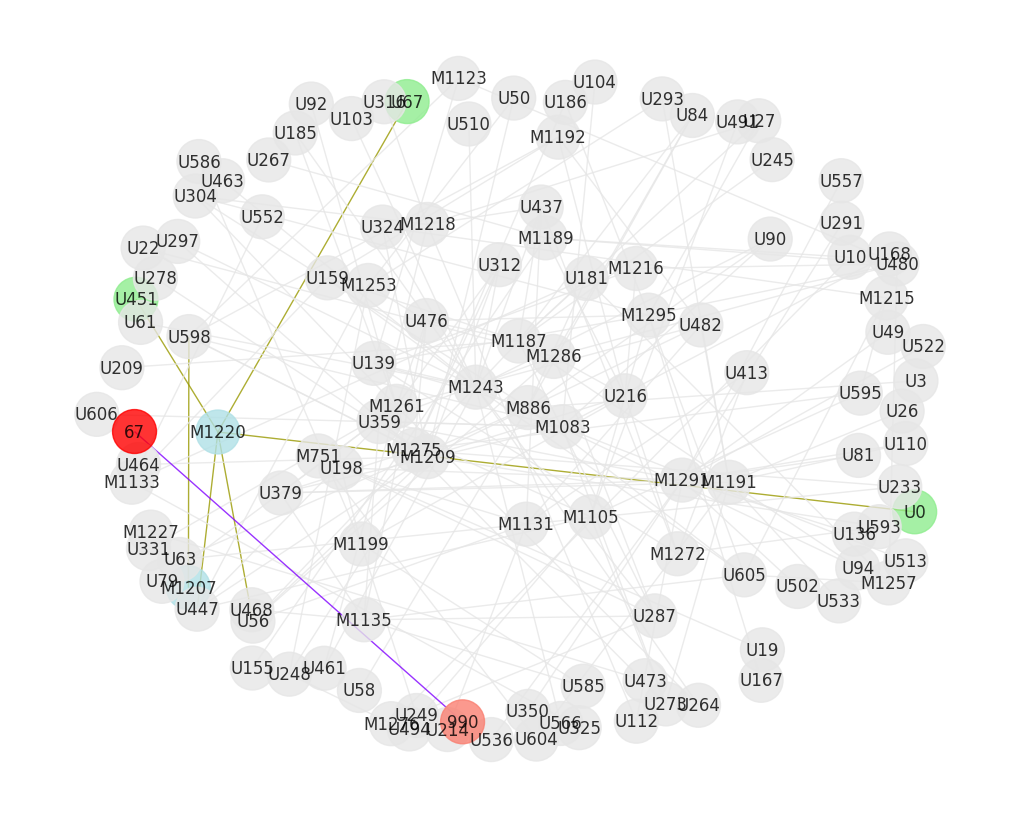

Graph with 121 nodes and 201 edges


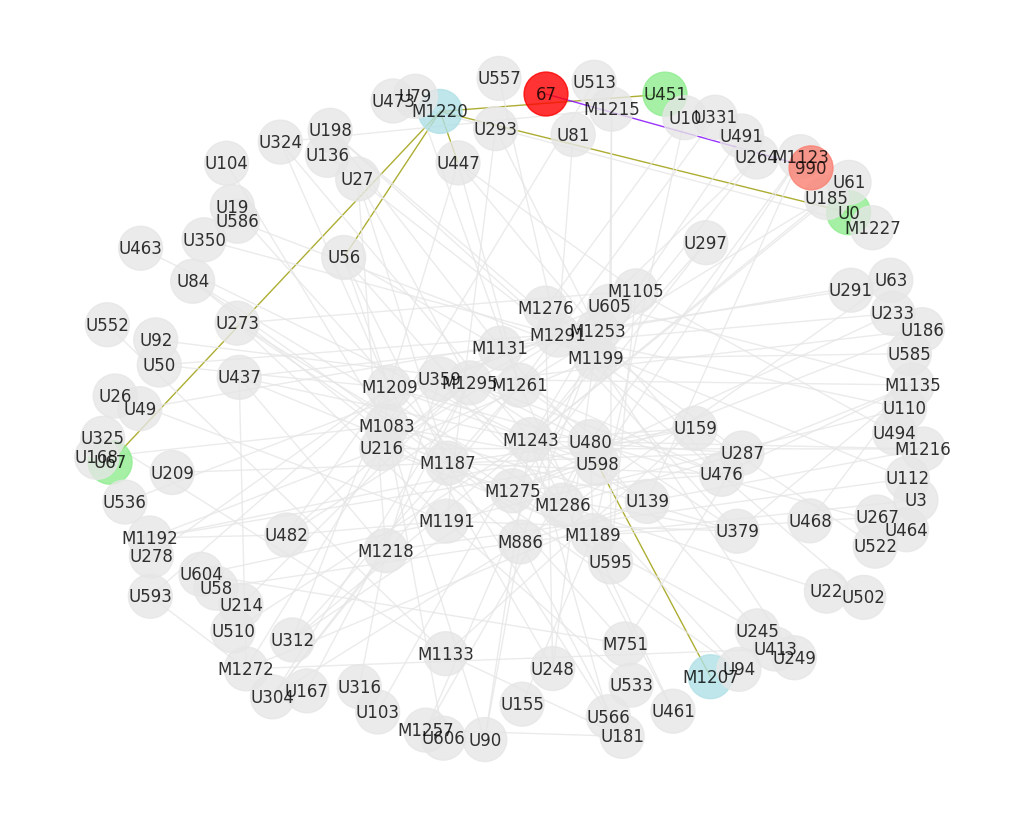

Graph with 121 nodes and 201 edges


In [146]:
for i in range(10):
    get_subgraphs(g,threshold = 0.001)

In [147]:
!pip freeze

absl-py==1.4.0
accelerate==1.8.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.23.0.39.50
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.8.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.5.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
captum==0.8.0
catalogue==2.0.10
certifi==2025.6.15
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.1
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake==3